# Evaluation with the distribution of the points pairwise distances and chamfer distance

Here we develop a new metrics to evaluate the generated point cloud. 

## Distribution of the points pairwise distances
Given a ground truth point cloud G we measure the distances from each point to each other point in the same cloud. We store those values in a matrix that we call points pairwise distances matrix. Specifically, this matrix is symmetric with all the elements in the diagonal equal to zero. Due to the fact that encode the distance between the point itself. The points pairwise distances matrix encodes in the columns the pieces of information related to the point and where this point is placed with respect to the others points in the same cloud. If we switch this set of multidimensional observations into a distribution we have the distribution of the pairwise distances between the points in the same cloud. If we normalize those distances, even if the object is rotated or translated the points pairwise distances matrix should be similar if the two objects are similar. Additionally, if we normalize those distances, even if the two objects are rotated or translated in different ways the points pairwise distances matrix should be similar if the two objects are similar (we made an illustration in the report to explain visually that). Therefore, we compared the generated point cloud pairwise distance distribution with the ground truth point cloud pairwise distance distribution in a plot. If the two distributions are overlapped that means that the combinations of the observed distances in the generated cloud fit the combinations of the observed distances of the ground truth object.


As future developments, instead of looking only at the overlap between the two distributions, we may desire to encode this overlap in one single number. It is possible to compute an approximation of the overlap between the two distributions with the well-known statistical divergence measure [Bhattacharyya distance](https://en.wikipedia.org/wiki/Bhattacharyya_distance).

## Chamfer Distance (CD)

In this [youtube](https://www.youtube.com/watch?v=P4IyrsWicfs) video they provided an incredible visual interpretation of the Chamfer distance. For each point in clouds S1 and S2, we try to find the closest point in the other cloud. Secondly, we perform the sum over all the minimum distances between the points squared. Here the formula:

(-0.5, 1703.5, 219.5, -0.5)

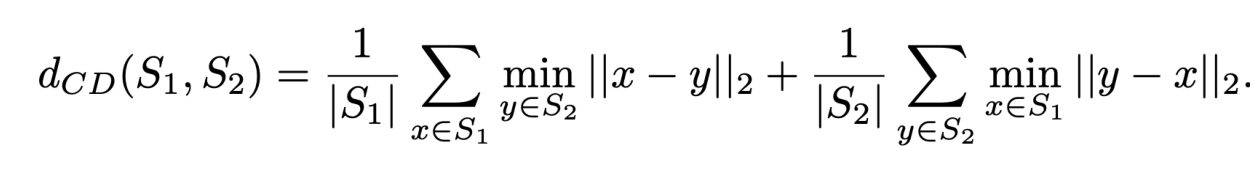

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.imshow(plt.imread('../../../chamferdistance.png'))
plt.axis('off')



In [1]:
import torch

# add path for demo utils functions 
import sys
import os

need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.13.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'


from scipy.spatial import distance
import tqdm
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Util function for loading meshes
import pytorch3d
from pytorch3d.io import load_objs_as_meshes, load_obj
# Data structures and functions for rendering
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import chamfer_distance
from pytorch3d.structures import Meshes
from pytorch3d.io import IO
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor,
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    SoftSilhouetteShader,
    PointsRasterizer,
    HardPhongShader,
    TexturesVertex
)

!pip install trimesh # install trimesh
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(1234)


!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid


from tqdm import tqdm
from PIL import Image, ImageDraw

# Setup cuda
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 KB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61431 sha256=e5b7fb9b5adafcc0863d0da7a83f83a8404315acb6f11333329995013c17ee4b
  Stored in directory: /root/.cache/pip/wheels/b8/79/07/c0e9367f5b5ea325e246bd73651e8af175fabbef943043b1cc
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31547 sha256=ab0db9e660bb3f6ed9a7595cbb1a6f518a8e5a97f7662d487ef4ec925e294e96
  Stored in directory: /root/.cache/pip/wheels/89/3e/24/0f349c0b2eeb6965903035f3b00dbb5c9bea437b4a2f18d82c
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py38_cu116_pyt1131/dow

In [4]:
# image generator
def image_gen(renders):
  '''
        Generate from the renders a list of images
        in:     renders, list of array (n_views, 512, 512, 3)
        out:    images, list of PIL images (n_views, 512, 512, 3)

   '''
  images = []
  for i, r in enumerate(renders):
      image = Image.fromarray((r * 255).astype(np.uint8))
      draw = ImageDraw.Draw(image)
      images.append(np.array(image))
  return images

# Setup cuda
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# that function render the pointcloud
def get_points_renderer(
    image_size=512, device=None, radius=0.01, background_color=(1, 1, 1)
):
    """ source: https://github.com/learning3d/assignment1/blob/master/starter/utils.py
    Returns a Pytorch3D renderer for point clouds.
    Args:
        image_size (int): The rendered image size.
        device (torch.device): The torch device to use (CPU or GPU). If not specified,
            will automatically use GPU if available, otherwise CPU.
        radius (float): The radius of the rendered point in NDC.
        background_color (tuple): The background color of the rendered image.
    
    Returns:
        PointsRenderer.
    """
    if device is None:
        if torch.cuda.is_available():
            device = torch.device("cuda:0")
        else:
            device = torch.device("cpu")
    raster_settings = PointsRasterizationSettings(image_size=image_size, radius=radius,)
    renderer = PointsRenderer(
        rasterizer=PointsRasterizer(raster_settings=raster_settings),
        compositor=AlphaCompositor(background_color=background_color),
    )
    return renderer

def get_mesh_renderer(image_size=512, lights=None, device=None):
    """
    Returns a Pytorch3D Mesh Renderer.
    Args:
        image_size (int): The rendered image size.
        lights: A default Pytorch3D lights object.
        device (torch.device): The torch device to use (CPU or GPU). If not specified,
            will automatically use GPU if available, otherwise CPU.
    """
    if device is None:
        if torch.cuda.is_available():
            device = torch.device("cuda:0")
        else:
            device = torch.device("cpu")
    raster_settings = RasterizationSettings(
        image_size=image_size, blur_radius=0.0, faces_per_pixel=1,
    )
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(cameras=cameras,raster_settings=raster_settings),
        shader=HardPhongShader(device=device, lights=lights),
    )
    return renderer

# Distribution Score

For the sake of this experiment, we used the euclidean distance. There is actually the possibility to extend the euclidean distance with other types of distance and check what happens ([Minkowski](https://en.wikipedia.org/wiki/Minkowski_distance), [Cityblock](https://en.wikipedia.org/wiki/Taxicab_geometry), [Chebyshev](https://en.wikipedia.org/wiki/Chebyshev_distance), [Harvesine](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html)...).

To speed up the calculation we compute the distances with the GPU with Cuda. Calculated the points pairwise distances matrix we generate the distribution with pandas.plot.kde.
[KDE](https://en.wikipedia.org/wiki/Kernel_density_estimation) is a non-parametric approach in which we use a kernel to estimate the PDF of our random variable. In this experiment we used the default gaussian kernel with bw_method=0.4. The bw_method defines the width of the kernel. The smaller it is the more will consider only the closest values in that region. The larger it is the smoother will be the estimation


In [7]:
import numpy as np
from numba import cuda

USE_64 = True

if USE_64:
    bits = 64
    np_type = np.float64
else:
    bits = 32
    np_type = np.float32

@cuda.jit("void(float{}[:, :], float{}[:, :])".format(bits, bits))
def distance_matrix(mat, out):
    m = mat.shape[0]
    n = mat.shape[1]
    i, j = cuda.grid(2)
    d = 0
    if i < m and j < m:
        for k in range(n):
            tmp = mat[i, k] - mat[j, k]
            d += tmp * tmp
        out[i, j] = d

def gpu_dist_matrix(mat):
    rows = mat.shape[0]

    block_dim = (16, 16)  # number of threads in a block
    grid_dim = (int(rows/block_dim[0] + 1), int(rows/block_dim[1] + 1)) # dimensions of the grid

    stream = cuda.stream()
    mat2 = cuda.to_device(np.asarray(mat, dtype=np_type), stream=stream)
    out2 = cuda.device_array((rows, rows))
    distance_matrix[grid_dim, block_dim](mat2, out2)
    out = out2.copy_to_host(stream=stream)

    return out


# I generate the point cloud of two different objects

verts, faces, _ = load_obj("/airboat.obj")
mesh = Meshes(verts=[verts], faces=[faces.verts_idx]).to(device)
point_cloud = sample_points_from_meshes(mesh, 4096)

# generate the distance matrix between each pair of variables
X=np.array(gpu_dist_matrix(point_cloud[0].cpu()))


verts, faces, _ = load_obj("/al.obj")
mesh = Meshes(verts=[verts], faces=[faces.verts_idx]).to(device)
point_cloud = sample_points_from_meshes(mesh, 4096)

# generate the distance matrix between each pair of variables
Y=np.array(gpu_dist_matrix(point_cloud[0].cpu()))


verts, faces, _ = load_obj("/sandal.obj")
mesh = Meshes(verts=[verts], faces=[faces.verts_idx]).to(device)
point_cloud = sample_points_from_meshes(mesh, 4096)

# generate the distance matrix between each pair of variables
Z=np.array(gpu_dist_matrix(point_cloud[0].cpu()))

<ipython-input-8-1173ebf96727>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.axes()


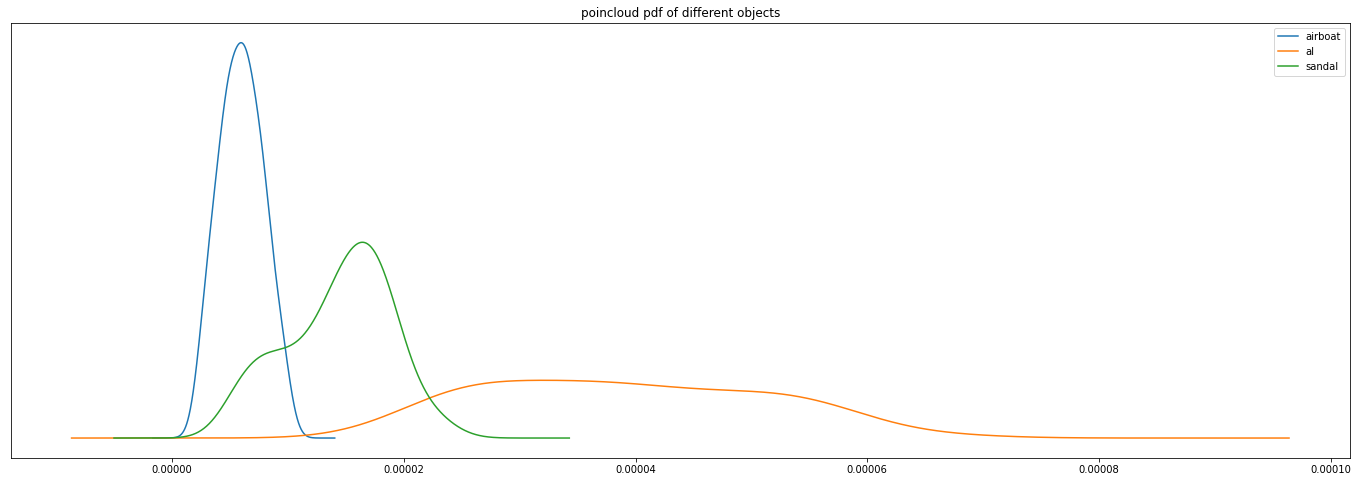

In [8]:
s = pd.DataFrame({
    'airboat': [1/i.sum() for i in X],
    'al': [1/i.sum() for i in Y],
    'sandal': [1/i.sum() for i in Z],
  })

s.plot.kde(bw_method=0.4,figsize=(24,8),title='poincloud pdf of different objects')
ax1 = plt.axes()
y_axis = ax1.axes.get_yaxis()
y_axis.set_visible(False)
plt.show()
plt.close()

# Generate the object with point-e


In [9]:
!git clone -b multiview https://github.com/halixness/point-e
%cd point-e/

Cloning into 'point-e'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 168 (delta 38), reused 34 (delta 23), pack-reused 94
Receiving objects: 100% (168/168), 7.69 MiB | 24.62 MiB/s, done.
Resolving deltas: 100% (58/58), done.
/content/point-e


In [10]:
!pip install -e .
!pip install diffusers transformers accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/point-e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-87qx5ndj/clip_4cf7372b58c44d0f87fa2b5ddf19af3b
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-87qx5ndj/clip_4cf7372b58c44d0f87fa2b5ddf19af3b
  Resolved https://github.com/openai/CLIP.git to commit 3702849800aa56e2223035bccd1c6ef91c704ca8
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 KB 2

In [11]:
from PIL import Image
import torch
from tqdm.auto import tqdm
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from diffusers import StableDiffusionInpaintPipeline, DPMSolverMultistepScheduler


# setup cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
!wget https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj

verts, faces, _ = load_obj("teapot.obj")

mesh = Meshes(verts=[verts], faces=[faces.verts_idx]).to(device)
# add texture
t=verts
a = (torch.sin(t)*torch.sin(torch.rand((t.shape)))).to(device)
c = ((a/(torch.zeros((t.shape)).to(device)+2))+0.5).to(device)
verts_rgb = c[None,:]
mesh.textures = TexturesVertex(verts_features=verts_rgb) 

--2023-02-08 20:59:45--  https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152595 (149K) [text/plain]
Saving to: ‘teapot.obj.7’

teapot.obj.7        100%[===================>] 149.02K   787KB/s    in 0.2s    

2023-02-08 20:59:46 (787 KB/s) - ‘teapot.obj.7’ saved [152595/152595]



  0%|          | 0/4 [00:00<?, ?it/s]

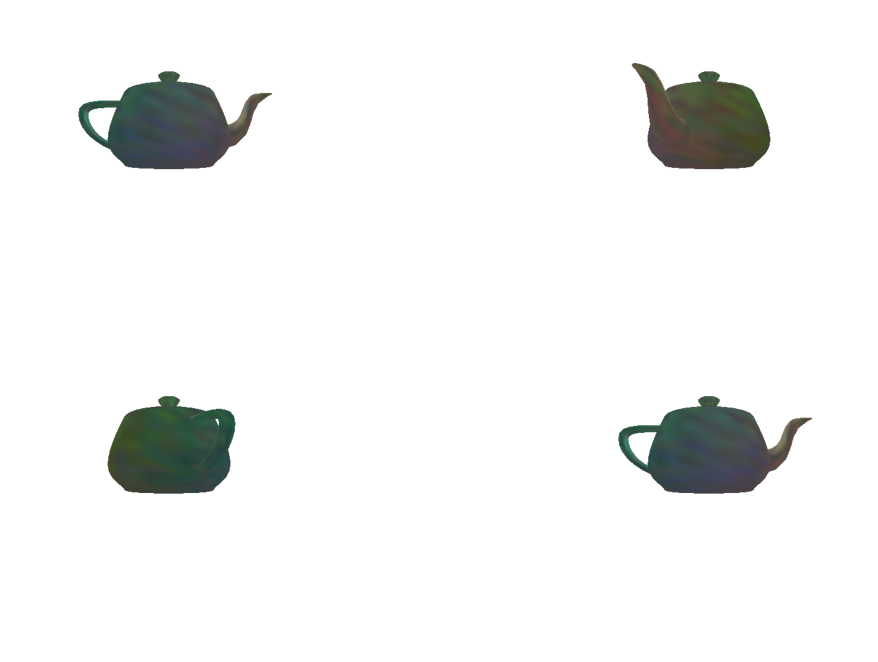

In [32]:
num_img = 4

renders = []
angles = np.linspace(0,360,num_img)
for i, angle in enumerate(tqdm(angles)):
    R, T = pytorch3d.renderer.look_at_view_transform(dist=3.0, elev=2, azim=angle)
    cameras = pytorch3d.renderer.FoVPerspectiveCameras(R=R, T=T, device=device)
    renderer=get_mesh_renderer(device=device)
    rend = renderer(mesh, cameras=cameras)
    rend = rend.cpu().numpy()
    renders.append(rend[0])
image_grid(torch.Tensor(renders).numpy(), rows=2, cols=2, rgb=True)
plt.show()

In [33]:
images=image_gen(renders)

In [34]:
len(images) #number of images

4

**from images to point cloud**

In [35]:
from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [36]:
base_name = 'base300M' # base40M, use base300M or base1B for better results

MODEL_CONFIGS[base_name]["n_views"] = 1
MODEL_CONFIGS['upsample']["n_views"] = 1

print('creating base model...')
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...


100%|███████████████████████████████████████| 890M/890M [00:11<00:00, 78.0MiB/s]


[-] Low Res Diff Transformer set with 1024+256*1 input tokens.
creating upsample model...
[-] High Res Diff Transformer set with 3072+256*1 input tokens.
downloading base checkpoint...


  0%|          | 0.00/1.25G [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [37]:
num_points = 1024

sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[num_points, 4096-num_points], # points in cloud and missing ones for upsampling
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [38]:
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=images))):
    samples = x

0it [00:00, ?it/s]

In [39]:
print("size of the point cloud",samples.shape)

size of the point cloud torch.Size([1, 6, 4096])


In [40]:
gen_pointcloud = samples[0, :3, :]
# reshape the point cloud
pc = sampler.output_to_point_clouds(samples)[0]
gen_pointcloud = torch.Tensor(pc.coords)
print('shape: ',gen_pointcloud.shape)

shape:  torch.Size([4096, 3])


In [41]:
original = sample_points_from_meshes(mesh, num_samples=4096).cpu()[0]
original = original.permute(1, 0)
blacks = torch.zeros((3, original.shape[1]))
original = torch.cat((original, blacks), 0).unsqueeze(0).cpu()
pc = sampler.output_to_point_clouds(original)[0]
original = torch.Tensor(pc.coords)

print('shape: ',original.shape)

shape:  torch.Size([4096, 3])


In [42]:
# generate the distance matrix between each pair of variables
X=np.array(gpu_dist_matrix(original.cpu()))

# generate the distance matrix between each pair of variables
Y=np.array(gpu_dist_matrix(gen_pointcloud.cpu()))


In [43]:
# This step is important to center the two pointcloud
XX=np.multiply(((Y).max()/(X).max()),X)
#YY=np.multiply(((X).max()/(Y).max()),Y)

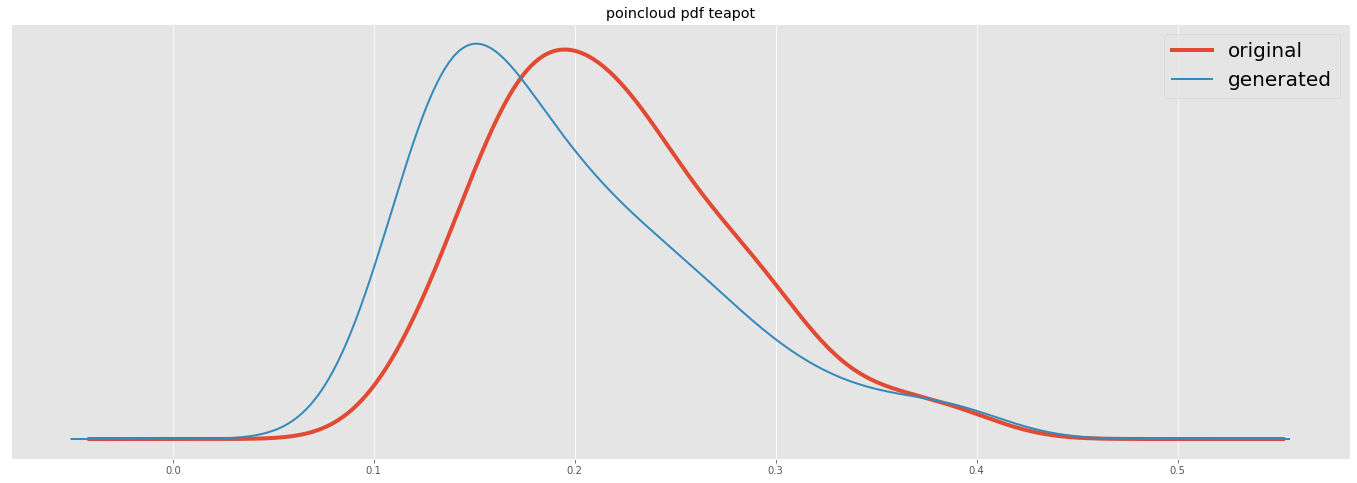

In [44]:
# generate the plot
s = pd.DataFrame({
    'original': [i.max() for i in XX],
    'generated': [i.max() for i in Y],
  })


plt.style.use('ggplot')
s['original'].plot.kde(bw_method=0.4,figsize=(24,8),legend="original",title='poincloud pdf teapot',logx=False ,linestyle='-',linewidth= 4).legend(fontsize=20, loc="upper right")
s['generated'].plot.kde(bw_method=0.4,figsize=(24,8),legend="generated",title='poincloud pdf teapot',logx=False ,linestyle='-',linewidth= 2).legend(fontsize=20, loc="upper right")
ax1 = plt.axes()
y_axis = ax1.axes.get_yaxis()
y_axis.set_visible(False)
plt.show()
plt.close()

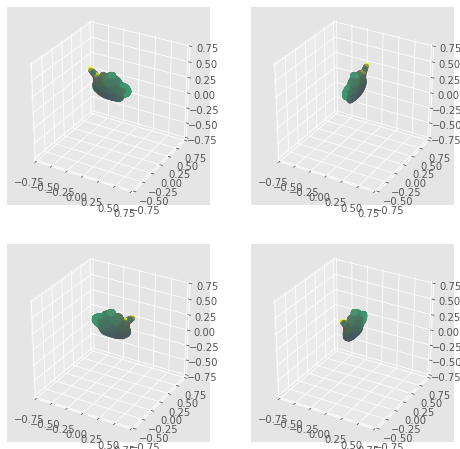

In [45]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=2, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

Now I try to add different object to check the distributions

In [46]:
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl

--2023-02-08 21:08:15--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj’

cow.obj             100%[===================>] 322.91K  1.52MB/s    in 0.2s    

2023-02-08 21:08:16 (1.52 MB/s) - ‘data/cow_mesh/cow.obj’ saved [330659/330659]

--2023-02-08 21:08:16--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl’

cow.mtl             100%[=======

In [47]:
v, f, _ = load_obj("data/cow_mesh/cow.obj")

m = Meshes(verts=[v], faces=[f.verts_idx]).to(device)
# add texture
verts_rgb = torch.abs(torch.sin(torch.stack([torch.arange(0,m.verts_list()[0].shape[0]),torch.arange(0,m.verts_list()[0].shape[0]),torch.arange(0,m.verts_list()[0].shape[0])],dim=1))).to(device)
verts_rgb = verts_rgb[None,:]
m.textures = TexturesVertex(verts_features=verts_rgb) 

In [48]:
o_new = sample_points_from_meshes(m, num_samples=4096).cpu()[0]
o_new = o_new.permute(1, 0)
blacks = torch.zeros((3, o_new.shape[1]))
o_new = torch.cat((o_new, blacks), 0).unsqueeze(0).cpu()
pc = sampler.output_to_point_clouds(o_new)[0]
o_new = torch.Tensor(pc.coords)

print('shape: ',o_new.shape)

# generate the distance matrix between each pair of variables
O_NEW=np.array(gpu_dist_matrix(o_new.cpu()))

O_NEW = np.multiply(((Y).max()/(O_NEW).max()),O_NEW)

shape:  torch.Size([4096, 3])


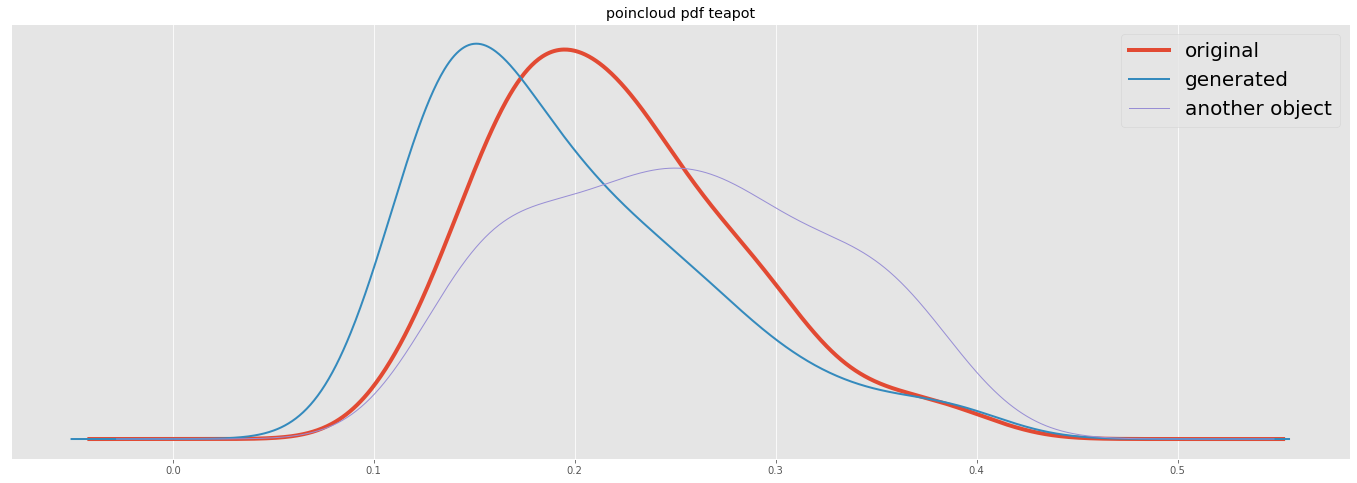

In [49]:
# generate the plot
s = pd.DataFrame({
    'original': [i.max() for i in XX],
    'generated': [i.max() for i in Y],
    'another object': [i.max() for i in O_NEW],
  })


plt.style.use('ggplot')
s['original'].plot.kde(bw_method=0.4,figsize=(24,8),legend="original",title='poincloud pdf teapot',logx=False ,linestyle='-',linewidth= 4).legend(fontsize=20, loc="upper right")
s['generated'].plot.kde(bw_method=0.4,figsize=(24,8),legend="generated",title='poincloud pdf teapot',logx=False ,linestyle='-',linewidth= 2).legend(fontsize=20, loc="upper right")
s['another object'].plot.kde(bw_method=0.4,figsize=(24,8),legend="another object",title='poincloud pdf teapot',logx=False ,linestyle='-',linewidth= 1).legend(fontsize=20, loc="upper right")
ax1 = plt.axes()
y_axis = ax1.axes.get_yaxis()
y_axis.set_visible(False)
plt.show()
plt.close()

***Chamfer Distance***

Chamfer Distance (CD) is a evaluation metric for two point clouds. It takes the distance of each points into account. For each point in each cloud, CD finds the nearest point in the other point set, and sums the square of distance up. It is utilized in Shapenet's shape reconstruction challenge.



In [ ]:
loss_chamfer, _ = chamfer_distance(original.cpu()[None,:], gen_pointcloud.cpu()[None,:])

In [ ]:
print('loss chamfer distance: ',loss_chamfer)

loss chamfer distance:  tensor(0.4201)


In [51]:
from PIL import Image
import torch
from tqdm.auto import tqdm
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import argparse
from sklearn.neighbors import KernelDensity
from scipy.stats import wasserstein_distance

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config

from point_e.evals.feature_extractor import PointNetClassifier, get_torch_devices
from point_e.evals.fid_is import compute_statistics
from point_e.evals.fid_is import compute_inception_score

In [65]:
def views_to_pointcloud(views, n_views=1):
    """ 
        Add zero color to a point cloud 
        in:     Tensor(n, w, h, 3), int(n)
        out:    Tensor(1, K, (x, y, z, r, g, b))
    """

    base_name = 'base300M' # base40M, use base300M or base1B for better results

    MODEL_CONFIGS[base_name]["n_views"] = n_views
    MODEL_CONFIGS['upsample']["n_views"] = n_views

    print('[-] creating base model...')
    base_model = model_from_config(MODEL_CONFIGS[base_name], device)
    base_model.eval()
    base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

    print('[-] creating upsample model...')
    upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
    upsampler_model.eval()
    upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

    print("[-] Loading pretrained models...")
    base_model.load_state_dict(load_checkpoint(base_name, device))
    upsampler_model.load_state_dict(load_checkpoint('upsample', device))

    sampler = PointCloudSampler(
        device=device,
        models=[base_model, upsampler_model],
        diffusions=[base_diffusion, upsampler_diffusion],
        num_points=[num_points, 4096-num_points], # points in cloud and missing ones for upsampling
        aux_channels=['R', 'G', 'B'],
        guidance_scale=[3.0, 3.0],
    )

    # Produce a sample from the model.
    samples = None
    for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=views))):
        samples = x

    del sampler
    return samples

# ----------------------------------------------
def cloud_distance(cloud1, cloud2, metric=None):
    """ 
        Compute distance between 1d distributions of cloud p2 norms 
        in:     Tensor((x, y, z), K), Tensor((x, y, z), K) 
        out:    Float
    """
    D1 = torch.cdist(cloud1, cloud1, p=2)
    D2 = torch.cdist(cloud2, cloud2, p=2)
    X1 = [float(1/i.sum()) for i in D1]
    X2 = [float(1/i.sum()) for i in D2]
    
    if metric == "gaussian":
        return np.mean(((np.mean(X1) - np.mean(X2))**2).sum()) / (np.std(X1)**2 + np.std(X2)**2)
    else:
        return wasserstein_distance(X1, X2) * 1e5

def plot_distributions(cloud1, cloud2, labels=["cloud1", "cloud2"], idx=0):
    """ 
        Plot 1d distributions of cloud p2 norms 
        in:     Tensor(K, c), Tensor(K, c) 
    """
    D1 = torch.cdist(cloud1, cloud1, p=2)
    D2 = torch.cdist(cloud2, cloud2, p=2)
    
    s = pd.DataFrame({
        labels[0]: [float(1/i.sum()) for i in D1],
        labels[1]: [float(1/i.sum()) for i in D2],
      })
    plt.style.use('ggplot')
    s[labels[0]].plot.kde(bw_method=0.4,figsize=(24,8),legend=labels[0],title='poincloud pdf of different objects',logx=False ,linestyle='-',linewidth= 2).legend(fontsize=20, loc="upper right")
    s[labels[1]].plot.kde(bw_method=0.4,figsize=(24,8),legend=labels[1],title='poincloud pdf of different objects',logx=False ,linestyle='-',linewidth= 2).legend(fontsize=20, loc="upper right")
    plt.savefig(f"{idx}_{labels[0]}_{labels[1]}.png")
    
def PIS(clf, cloud):
    """
        Compute P-IS score for a cloud
        in:     PointNetClassifier, Tensor(c, K)
        out:    Float
        https://github.com/halixness/point-e/blob/69e677d8ea47593c33fe2f52fd40e131054c9ce3/point_e/evals/fid_is.py#L73
    """
    cloud = cloud.permute(1,0).unsqueeze(0).cpu().numpy()
    _, preds = clf.features_and_preds(cloud)

    return np.exp(
      np.sum(
        preds[0] * ( np.log(preds[0]) - np.log(np.mean(preds[0])) )
      )
    )

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ToPILImage = transforms.ToPILImage()
num_points = 1024

# **uniform texture modelnet40**

In [61]:
import os

base_path = os.path.join("model_net_csinrand")
views = torch.load(os.path.join(base_path, "images_obj.pt"))
point_clouds = torch.load(os.path.join(base_path, "points.pt"))

In [63]:
ground_objs = []
limit = 10

for i in range(views.shape[0]):
    ground_objs.append([ToPILImage(views[i, j, :, :, :3]) for j in range(4)])

In [64]:
gen_clouds = torch.zeros((len(ground_objs), 2, 6, 4096)) # N, 2, c, K

for i, obj in enumerate(ground_objs):
    
    # Point cloud from single view
    print("====== Single view ======")
    gen_clouds[i, 0, :, :] = views_to_pointcloud(views = [obj[0]], n_views = 1)

    torch.cuda.empty_cache()

    # Point cloud from multi view
    print("\n====== Multi view ======")
    gen_clouds[i, 1, :, :] = views_to_pointcloud(views = obj, n_views = len(obj))
    
    torch.cuda.empty_cache()
    
    if i == limit: break

====== Single view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*1 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*1 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]


====== Multi view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*4 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*4 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]

====== Single view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*1 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*1 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]


====== Multi view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*4 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*4 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]

====== Single view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*1 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*1 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]


====== Multi view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*4 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*4 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]

====== Single view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*1 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*1 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]


====== Multi view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*4 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*4 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]

====== Single view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*1 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*1 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]


====== Multi view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*4 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*4 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]

====== Single view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*1 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*1 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]


====== Multi view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*4 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*4 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]

====== Single view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*1 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*1 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]


====== Multi view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*4 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*4 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]

====== Single view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*1 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*1 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]


====== Multi view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*4 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*4 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]

====== Single view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*1 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*1 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]


====== Multi view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*4 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*4 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]

====== Single view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*1 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*1 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]


====== Multi view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*4 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*4 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]

====== Single view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*1 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*1 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]


====== Multi view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*4 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*4 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]

In [66]:
clf = PointNetClassifier(devices=get_torch_devices(), cache_dir=None)

  0%|          | 0.00/70.4M [00:00<?, ?iB/s]


====== [0] Point cloud divergences ======
[+] Ground truth - Single view divergence: 		108.67805662937435
[+] Ground truth - Multi view divergence: 		218.32645279968864
[+] Single view - Multi view divergence: 		109.6483961703143
[+] Ground truth P-IS: 		8.7105131149292
[+] Single view P-IS: 		22.673646926879883
[+] Multi view P-IS: 		29.954130172729492

====== [1] Point cloud divergences ======
[+] Ground truth - Single view divergence: 		93.38421588908075
[+] Ground truth - Multi view divergence: 		82.86015212107812
[+] Single view - Multi view divergence: 		15.072193127707578
[+] Ground truth P-IS: 		30.042991638183594
[+] Single view P-IS: 		8.52695083618164
[+] Multi view P-IS: 		27.22335433959961

====== [2] Point cloud divergences ======
[+] Ground truth - Single view divergence: 		53.48378266162579
[+] Ground truth - Multi view divergence: 		71.17761127687639
[+] Single view - Multi view divergence: 		17.693828615250595
[+] Ground truth P-IS: 		8.884458541870117
[+] Single vie

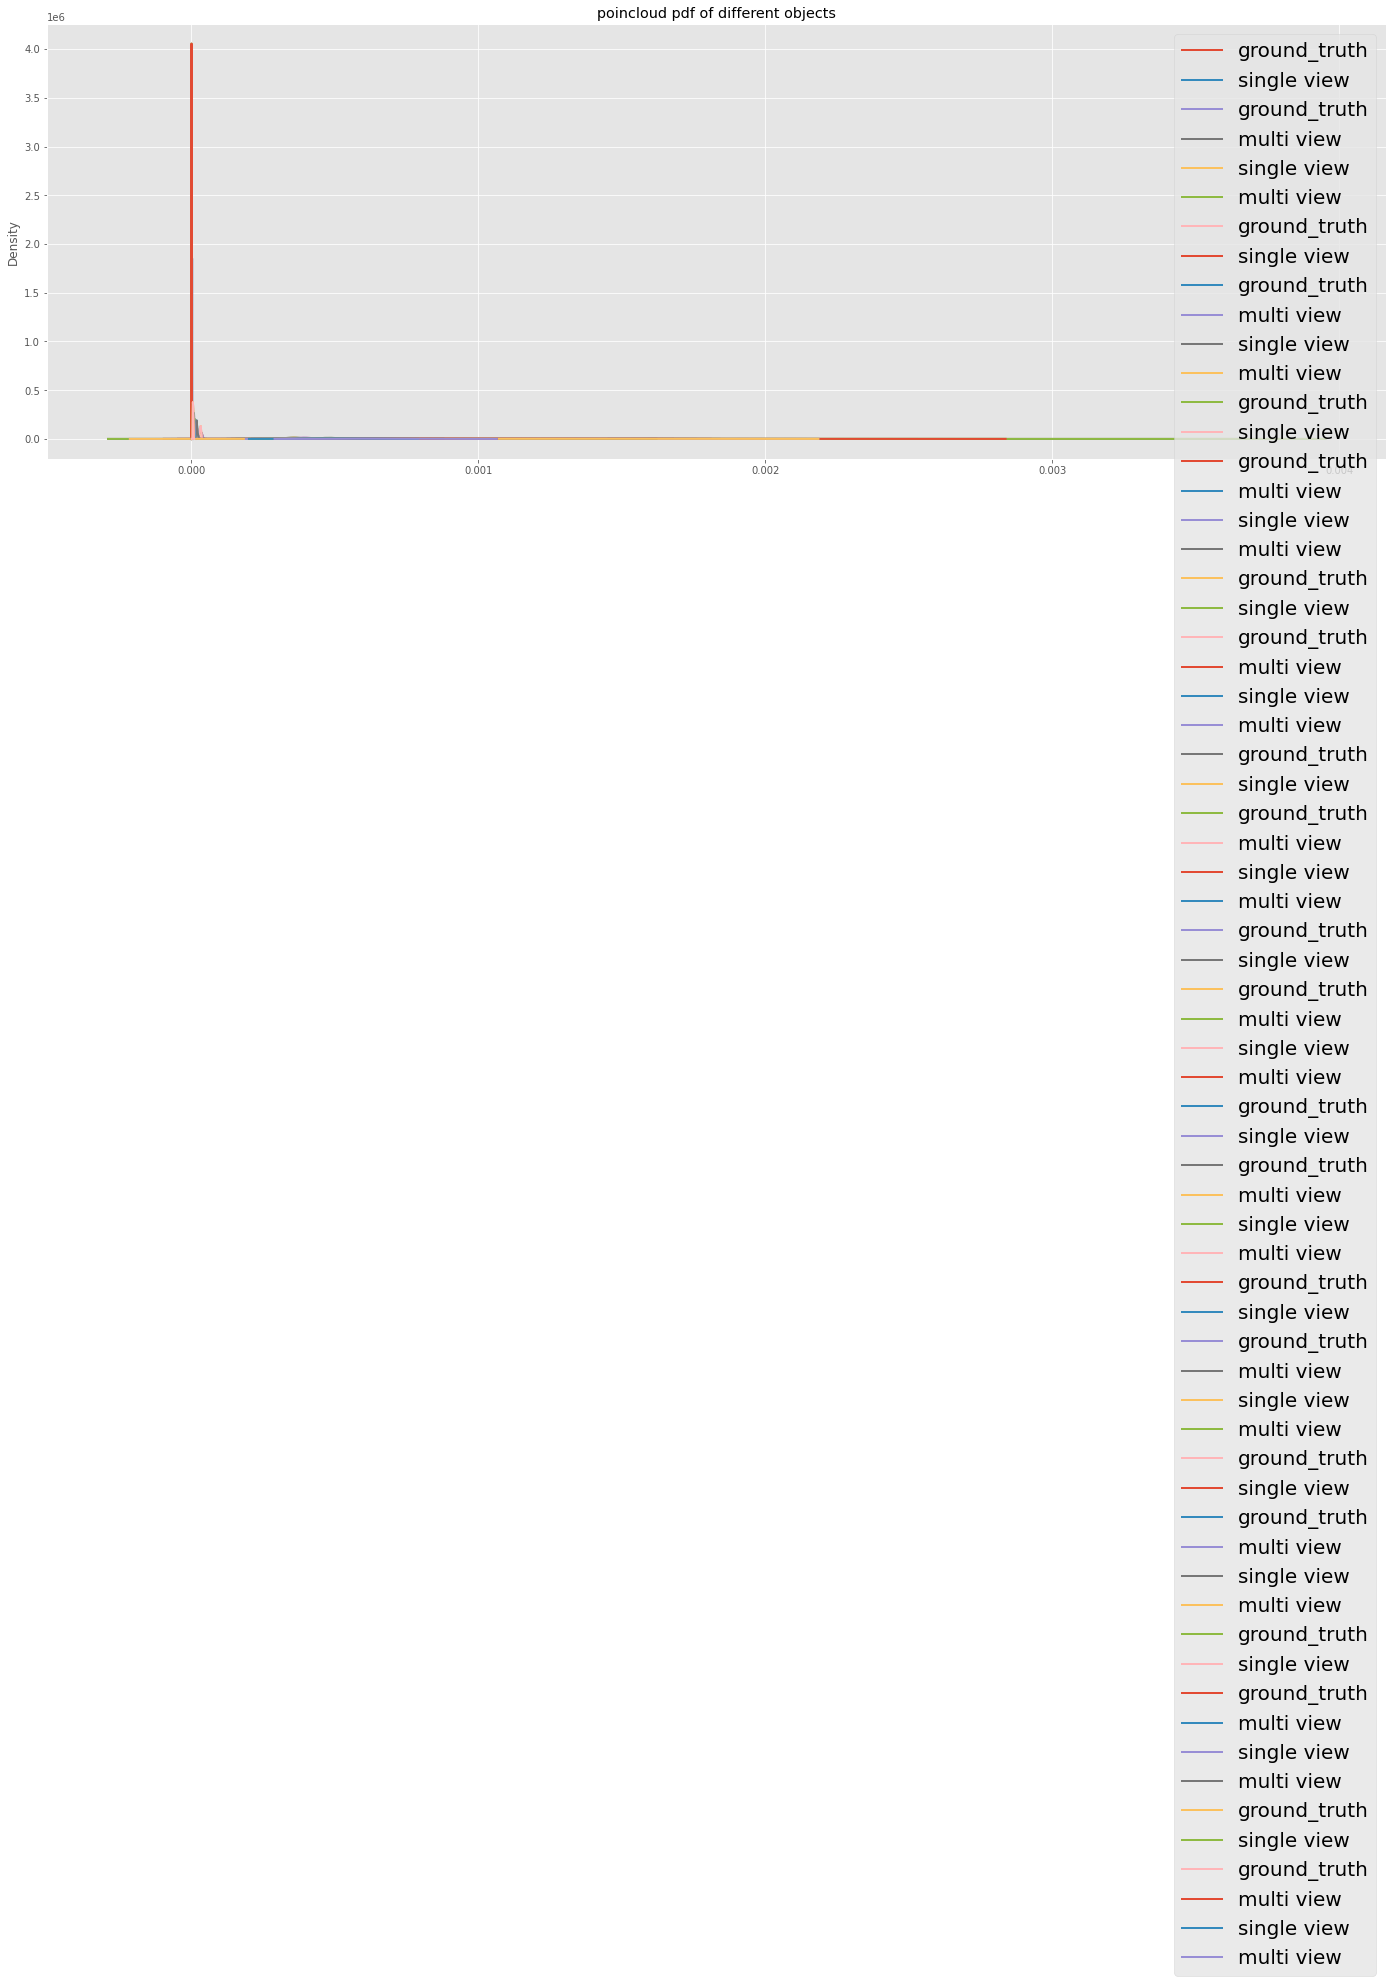

In [67]:
scores = torch.zeros((gen_clouds.shape[0], 3))
for i in range(gen_clouds.shape[0]):
    
    print(f"\n====== [{i}] Point cloud divergences ======")
    
    # ---- Ground - Gen. single
    d_ground_single = cloud_distance(
        torch.Tensor(point_clouds[i]), 
        gen_clouds[i, 0, :3, :].permute(1,0)
    )
    
    print("[+] Ground truth - Single view divergence: \t\t{}".format(d_ground_single))

    plot_distributions(
        torch.Tensor(point_clouds[i]),
        gen_clouds[i, 0, :3, :].permute(1,0),
        ["ground_truth", "single view"], 
        i
    )

    # ---- Ground - Gen. multi
    d_ground_multi = cloud_distance(
        torch.Tensor(point_clouds[i]), 
        gen_clouds[i, 1, :3, :].permute(1,0)
    )
    print("[+] Ground truth - Multi view divergence: \t\t{}".format(d_ground_multi))

    plot_distributions(
        torch.Tensor(point_clouds[i]),
        gen_clouds[i, 1, :3, :].permute(1,0),
        ["ground_truth", "multi view"], 
        i
    )

    # ---- Gen. single - Gen. multi
    d_single_multi = cloud_distance(
        gen_clouds[i, 0, :3, :].permute(1,0), 
        gen_clouds[i, 1, :3, :].permute(1,0)
    )
    print("[+] Single view - Multi view divergence: \t\t{}".format(d_single_multi))

    plot_distributions(
        gen_clouds[i, 0, :3, :].permute(1,0), 
        gen_clouds[i, 1, :3, :].permute(1,0), 
        ["single view", "multi view"], 
        i
    )
    
    print(f"[+] Ground truth P-IS: \t\t{PIS(clf, torch.Tensor(point_clouds[i]).permute(1,0))}")
    print(f"[+] Single view P-IS: \t\t{PIS(clf, gen_clouds[i, 0, :3, :])}")
    print(f"[+] Multi view P-IS: \t\t{PIS(clf, gen_clouds[i, 1, :3, :])}")
    
    scores[i, :] = torch.Tensor([d_ground_single, d_ground_multi, d_single_multi])
    
    if i == limit: break